# 3 layer LSTM Encoder Decoder, dropout. 30 day input, 7 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.6'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [3]:
num_input = 120
num_out = 3
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (568, 120, 25)
train_y shape (568, 3, 1)
dev_X shape (71, 120, 25)
dev_y shape (71, 3, 1)
test_X shape (72, 120, 25)
test_y shape (72, 3, 1)
train_y_acc shape (568, 3, 1)
dev_y_acc shape (71, 3, 1)
test_y_acc shape (72, 3, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(CuDNNLSTM(200, input_shape=input_shape))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               181600    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 200)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 3, 200)            321600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 100)            20100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 1)              101       
Total params: 523,401
Trainable params: 523,401
Non-trainable params: 0
_________________________________________________________________


In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 568 samples, validate on 71 samples
Epoch 1/1000
568/568 [==============================] - 2s 3ms/step - loss: 0.0291 - val_loss: 0.0086
Epoch 2/1000
568/568 [==============================] - 1s 953us/step - loss: 0.0079 - val_loss: 8.3830e-04
Epoch 3/1000
568/568 [==============================] - 1s 942us/step - loss: 0.0026 - val_loss: 7.2959e-04
Epoch 4/1000
568/568 [==============================] - 1s 938us/step - loss: 0.0017 - val_loss: 2.8251e-04
Epoch 5/1000
568/568 [==============================] - 1s 944us/step - loss: 0.0013 - val_loss: 2.6456e-04
Epoch 6/1000
568/568 [==============================] - 1s 939us/step - loss: 0.0011 - val_loss: 2.2537e-04
Epoch 7/1000
568/568 [==============================] - 1s 937us/step - loss: 0.0010 - val_loss: 2.6241e-04
Epoch 8/1000
568/568 [==============================] - 1s 939us/step - loss: 0.0012 - val_loss: 

568/568 [==============================] - 1s 940us/step - loss: 4.9914e-04 - val_loss: 7.0326e-04
Epoch 72/1000
568/568 [==============================] - 1s 938us/step - loss: 5.3906e-04 - val_loss: 8.8547e-04
Epoch 73/1000
568/568 [==============================] - 1s 938us/step - loss: 5.7550e-04 - val_loss: 0.0013
Epoch 74/1000
568/568 [==============================] - 1s 942us/step - loss: 4.5314e-04 - val_loss: 0.0012
Epoch 75/1000
568/568 [==============================] - 1s 941us/step - loss: 4.6480e-04 - val_loss: 0.0015
Epoch 76/1000
568/568 [==============================] - 1s 940us/step - loss: 4.7198e-04 - val_loss: 0.0020
Epoch 77/1000
568/568 [==============================] - 1s 938us/step - loss: 4.6165e-04 - val_loss: 0.0010
Epoch 78/1000
568/568 [==============================] - 1s 940us/step - loss: 5.5340e-04 - val_loss: 0.0020
Epoch 79/1000
568/568 [==============================] - 1s 937us/step - loss: 7.0552e-04 - val_loss: 0.0020
Epoch 80/1000
568/568 [==

568/568 [==============================] - 1s 939us/step - loss: 2.5921e-04 - val_loss: 0.0018
Epoch 146/1000
568/568 [==============================] - 1s 938us/step - loss: 2.5212e-04 - val_loss: 0.0011
Epoch 147/1000
568/568 [==============================] - 1s 938us/step - loss: 2.6749e-04 - val_loss: 0.0014
Epoch 148/1000
568/568 [==============================] - 1s 941us/step - loss: 2.6722e-04 - val_loss: 0.0014
Epoch 149/1000
568/568 [==============================] - 1s 941us/step - loss: 2.5029e-04 - val_loss: 0.0014
Epoch 150/1000
568/568 [==============================] - 1s 946us/step - loss: 2.5058e-04 - val_loss: 0.0016
Epoch 151/1000
568/568 [==============================] - 1s 941us/step - loss: 2.7570e-04 - val_loss: 0.0015
Epoch 152/1000
568/568 [==============================] - 1s 939us/step - loss: 2.7458e-04 - val_loss: 8.2410e-04
Epoch 153/1000
568/568 [==============================] - 1s 936us/step - loss: 2.4720e-04 - val_loss: 0.0017
Epoch 154/1000
568/56

568/568 [==============================] - 1s 936us/step - loss: 2.2172e-04 - val_loss: 0.0031
Epoch 220/1000
568/568 [==============================] - 1s 940us/step - loss: 2.3700e-04 - val_loss: 0.0019
Epoch 221/1000
568/568 [==============================] - 1s 941us/step - loss: 1.9903e-04 - val_loss: 0.0021
Epoch 222/1000
568/568 [==============================] - 1s 941us/step - loss: 1.8733e-04 - val_loss: 0.0023
Epoch 223/1000
568/568 [==============================] - 1s 936us/step - loss: 1.8512e-04 - val_loss: 0.0033
Epoch 224/1000
568/568 [==============================] - 1s 939us/step - loss: 2.1584e-04 - val_loss: 0.0028
Epoch 225/1000
568/568 [==============================] - 1s 940us/step - loss: 1.9371e-04 - val_loss: 0.0029
Epoch 226/1000
568/568 [==============================] - 1s 938us/step - loss: 1.6470e-04 - val_loss: 0.0023
Epoch 227/1000
568/568 [==============================] - 1s 936us/step - loss: 1.9886e-04 - val_loss: 0.0023
Epoch 228/1000
568/568 [=

568/568 [==============================] - 1s 943us/step - loss: 1.8743e-04 - val_loss: 0.0028
Epoch 294/1000
568/568 [==============================] - 1s 948us/step - loss: 3.5080e-04 - val_loss: 0.0031
Epoch 295/1000
568/568 [==============================] - 1s 947us/step - loss: 2.1184e-04 - val_loss: 0.0019
Epoch 296/1000
568/568 [==============================] - 1s 941us/step - loss: 1.6148e-04 - val_loss: 0.0021
Epoch 297/1000
568/568 [==============================] - 1s 942us/step - loss: 1.5237e-04 - val_loss: 0.0017
Epoch 298/1000
568/568 [==============================] - 1s 940us/step - loss: 1.5001e-04 - val_loss: 0.0031
Epoch 299/1000
568/568 [==============================] - 1s 944us/step - loss: 1.7142e-04 - val_loss: 0.0027
Epoch 300/1000
568/568 [==============================] - 1s 942us/step - loss: 1.7066e-04 - val_loss: 0.0026
Epoch 301/1000
568/568 [==============================] - 1s 940us/step - loss: 1.7846e-04 - val_loss: 0.0042
Epoch 302/1000
568/568 [=

568/568 [==============================] - 1s 940us/step - loss: 1.2782e-04 - val_loss: 0.0031
Epoch 368/1000
568/568 [==============================] - 1s 938us/step - loss: 1.0577e-04 - val_loss: 0.0031
Epoch 369/1000
568/568 [==============================] - 1s 941us/step - loss: 9.4755e-05 - val_loss: 0.0033
Epoch 370/1000
568/568 [==============================] - 1s 943us/step - loss: 1.1681e-04 - val_loss: 0.0037
Epoch 371/1000
568/568 [==============================] - 1s 939us/step - loss: 1.0324e-04 - val_loss: 0.0038
Epoch 372/1000
568/568 [==============================] - 1s 942us/step - loss: 1.0123e-04 - val_loss: 0.0035
Epoch 373/1000
568/568 [==============================] - 1s 941us/step - loss: 1.0230e-04 - val_loss: 0.0034
Epoch 374/1000
568/568 [==============================] - 1s 940us/step - loss: 9.0530e-05 - val_loss: 0.0037
Epoch 375/1000
568/568 [==============================] - 1s 941us/step - loss: 8.5744e-05 - val_loss: 0.0037
Epoch 376/1000
568/568 [=

568/568 [==============================] - 1s 940us/step - loss: 1.1743e-04 - val_loss: 0.0058
Epoch 442/1000
568/568 [==============================] - 1s 941us/step - loss: 1.0940e-04 - val_loss: 0.0053
Epoch 443/1000
568/568 [==============================] - 1s 941us/step - loss: 1.1027e-04 - val_loss: 0.0046
Epoch 444/1000
568/568 [==============================] - 1s 942us/step - loss: 1.0323e-04 - val_loss: 0.0059
Epoch 445/1000
568/568 [==============================] - 1s 941us/step - loss: 8.4525e-05 - val_loss: 0.0044
Epoch 446/1000
568/568 [==============================] - 1s 938us/step - loss: 9.1145e-05 - val_loss: 0.0051
Epoch 447/1000
568/568 [==============================] - 1s 940us/step - loss: 8.4859e-05 - val_loss: 0.0050
Epoch 448/1000
568/568 [==============================] - 1s 940us/step - loss: 1.3130e-04 - val_loss: 0.0050
Epoch 449/1000
568/568 [==============================] - 1s 939us/step - loss: 1.5064e-04 - val_loss: 0.0069
Epoch 450/1000
568/568 [=

568/568 [==============================] - 1s 942us/step - loss: 9.9151e-05 - val_loss: 0.0060
Epoch 516/1000
568/568 [==============================] - 1s 940us/step - loss: 1.3981e-04 - val_loss: 0.0054
Epoch 517/1000
568/568 [==============================] - 1s 939us/step - loss: 2.5503e-04 - val_loss: 0.0056
Epoch 518/1000
568/568 [==============================] - 1s 939us/step - loss: 3.2362e-04 - val_loss: 0.0061
Epoch 519/1000
568/568 [==============================] - 1s 936us/step - loss: 2.7171e-04 - val_loss: 0.0036
Epoch 520/1000
568/568 [==============================] - 1s 938us/step - loss: 1.9350e-04 - val_loss: 0.0069
Epoch 521/1000
568/568 [==============================] - 1s 945us/step - loss: 1.6660e-04 - val_loss: 0.0059
Epoch 522/1000
568/568 [==============================] - 1s 944us/step - loss: 1.2056e-04 - val_loss: 0.0049
Epoch 523/1000
568/568 [==============================] - 1s 942us/step - loss: 1.4906e-04 - val_loss: 0.0043
Epoch 524/1000
568/568 [=

568/568 [==============================] - 1s 941us/step - loss: 5.2597e-05 - val_loss: 0.0072
Epoch 590/1000
568/568 [==============================] - 1s 940us/step - loss: 5.6123e-05 - val_loss: 0.0064
Epoch 591/1000
568/568 [==============================] - 1s 944us/step - loss: 7.2643e-05 - val_loss: 0.0064
Epoch 592/1000
568/568 [==============================] - 1s 945us/step - loss: 6.3495e-05 - val_loss: 0.0066
Epoch 593/1000
568/568 [==============================] - 1s 943us/step - loss: 7.4633e-05 - val_loss: 0.0081
Epoch 594/1000
568/568 [==============================] - 1s 941us/step - loss: 7.6130e-05 - val_loss: 0.0080
Epoch 595/1000
568/568 [==============================] - 1s 942us/step - loss: 1.1228e-04 - val_loss: 0.0072
Epoch 596/1000
568/568 [==============================] - 1s 943us/step - loss: 8.9628e-05 - val_loss: 0.0070
Epoch 597/1000
568/568 [==============================] - 1s 946us/step - loss: 8.5818e-05 - val_loss: 0.0066
Epoch 598/1000
568/568 [=

568/568 [==============================] - 1s 960us/step - loss: 4.4051e-05 - val_loss: 0.0075
Epoch 664/1000
568/568 [==============================] - 1s 964us/step - loss: 3.9736e-05 - val_loss: 0.0083
Epoch 665/1000
568/568 [==============================] - 1s 968us/step - loss: 4.0463e-05 - val_loss: 0.0069
Epoch 666/1000
568/568 [==============================] - 1s 980us/step - loss: 3.7264e-05 - val_loss: 0.0062
Epoch 667/1000
568/568 [==============================] - 1s 973us/step - loss: 3.2866e-05 - val_loss: 0.0073
Epoch 668/1000
568/568 [==============================] - 1s 970us/step - loss: 3.2687e-05 - val_loss: 0.0068
Epoch 669/1000
568/568 [==============================] - 1s 982us/step - loss: 3.3058e-05 - val_loss: 0.0070
Epoch 670/1000
568/568 [==============================] - 1s 966us/step - loss: 4.2082e-05 - val_loss: 0.0076
Epoch 671/1000
568/568 [==============================] - 1s 964us/step - loss: 5.5569e-05 - val_loss: 0.0069
Epoch 672/1000
568/568 [=

568/568 [==============================] - 1s 940us/step - loss: 7.2204e-05 - val_loss: 0.0066
Epoch 738/1000
568/568 [==============================] - 1s 934us/step - loss: 7.2063e-05 - val_loss: 0.0070
Epoch 739/1000
568/568 [==============================] - 1s 940us/step - loss: 8.9740e-05 - val_loss: 0.0077
Epoch 740/1000
568/568 [==============================] - 1s 940us/step - loss: 1.1577e-04 - val_loss: 0.0074
Epoch 741/1000
568/568 [==============================] - 1s 939us/step - loss: 9.8811e-05 - val_loss: 0.0083
Epoch 742/1000
568/568 [==============================] - 1s 939us/step - loss: 6.3916e-05 - val_loss: 0.0065
Epoch 743/1000
568/568 [==============================] - 1s 937us/step - loss: 6.1017e-05 - val_loss: 0.0077
Epoch 744/1000
568/568 [==============================] - 1s 938us/step - loss: 9.1545e-05 - val_loss: 0.0061
Epoch 745/1000
568/568 [==============================] - 1s 935us/step - loss: 5.8963e-05 - val_loss: 0.0083
Epoch 746/1000
568/568 [=

568/568 [==============================] - 1s 942us/step - loss: 5.0077e-05 - val_loss: 0.0089
Epoch 812/1000
568/568 [==============================] - 1s 938us/step - loss: 5.3186e-05 - val_loss: 0.0068
Epoch 813/1000
568/568 [==============================] - 1s 938us/step - loss: 5.2152e-05 - val_loss: 0.0083
Epoch 814/1000
568/568 [==============================] - 1s 938us/step - loss: 6.5303e-05 - val_loss: 0.0085
Epoch 815/1000
568/568 [==============================] - 1s 935us/step - loss: 7.3527e-05 - val_loss: 0.0082
Epoch 816/1000
568/568 [==============================] - 1s 937us/step - loss: 5.0990e-05 - val_loss: 0.0071
Epoch 817/1000
568/568 [==============================] - 1s 935us/step - loss: 6.9126e-05 - val_loss: 0.0084
Epoch 818/1000
568/568 [==============================] - 1s 942us/step - loss: 5.5441e-05 - val_loss: 0.0075
Epoch 819/1000
568/568 [==============================] - 1s 939us/step - loss: 5.7725e-05 - val_loss: 0.0068
Epoch 820/1000
568/568 [=

568/568 [==============================] - 1s 937us/step - loss: 1.4579e-05 - val_loss: 0.0074
Epoch 886/1000
568/568 [==============================] - 1s 936us/step - loss: 1.3685e-05 - val_loss: 0.0080
Epoch 887/1000
568/568 [==============================] - 1s 936us/step - loss: 1.4583e-05 - val_loss: 0.0080
Epoch 888/1000
568/568 [==============================] - 1s 938us/step - loss: 1.4445e-05 - val_loss: 0.0079
Epoch 889/1000
568/568 [==============================] - 1s 938us/step - loss: 1.6777e-05 - val_loss: 0.0081
Epoch 890/1000
568/568 [==============================] - 1s 940us/step - loss: 2.1429e-05 - val_loss: 0.0076
Epoch 891/1000
568/568 [==============================] - 1s 936us/step - loss: 3.1788e-05 - val_loss: 0.0067
Epoch 892/1000
568/568 [==============================] - 1s 940us/step - loss: 3.9403e-05 - val_loss: 0.0082
Epoch 893/1000
568/568 [==============================] - 1s 940us/step - loss: 3.6569e-05 - val_loss: 0.0077
Epoch 894/1000
568/568 [=

568/568 [==============================] - 1s 944us/step - loss: 1.3481e-05 - val_loss: 0.0073
Epoch 960/1000
568/568 [==============================] - 1s 941us/step - loss: 1.6669e-05 - val_loss: 0.0074
Epoch 961/1000
568/568 [==============================] - 1s 937us/step - loss: 1.7365e-05 - val_loss: 0.0070
Epoch 962/1000
568/568 [==============================] - 1s 940us/step - loss: 1.9394e-05 - val_loss: 0.0072
Epoch 963/1000
568/568 [==============================] - 1s 938us/step - loss: 1.8977e-05 - val_loss: 0.0071
Epoch 964/1000
568/568 [==============================] - 1s 940us/step - loss: 1.7917e-05 - val_loss: 0.0076
Epoch 965/1000
568/568 [==============================] - 1s 940us/step - loss: 2.1687e-05 - val_loss: 0.0074
Epoch 966/1000
568/568 [==============================] - 1s 943us/step - loss: 2.6999e-05 - val_loss: 0.0074
Epoch 967/1000
568/568 [==============================] - 1s 941us/step - loss: 4.4374e-05 - val_loss: 0.0079
Epoch 968/1000
568/568 [=

In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 9.868494775479985e-06
MSE Dev: 0.007440385125088764
MSE Test: 0.002882887357748092


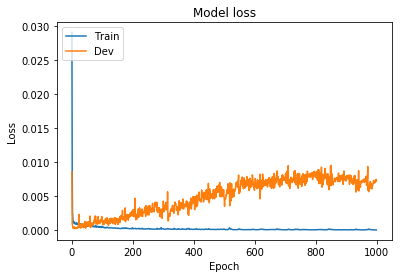

In [7]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

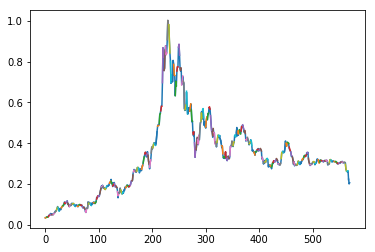

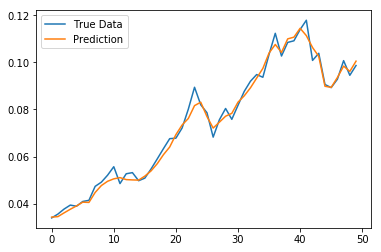

In [20]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[:, 0].reshape(-1,1)
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results(predicted_train[:50], true_train[:50])

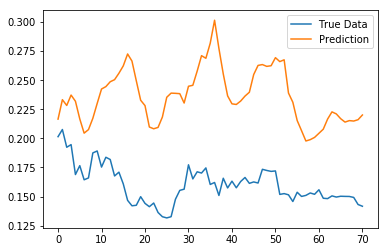

In [15]:
# predicted_dev = model.predict(dev_X).squeeze()
# predicted_dev = predicted_dev[::num_out]
# true_dev = dev_y[:, 0].reshape(-1,1)
# utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[:, 0].reshape(-1,1)
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results(predicted_dev, true_dev)

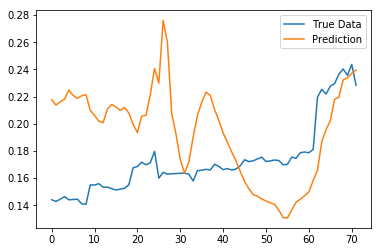

In [16]:
# predicted_test = model.predict(test_X).squeeze()
# predicted_test = predicted_test[::num_out]
# true_test = test_y[:, 0].reshape(-1,1)
# utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[:, 0].reshape(-1,1)
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results(predicted_test, true_test)

In [17]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 1.0208590598915674e-05
MSE Dev: 0.006443714434112535
MSE Test: 0.0022279786900634693


In [18]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.8606701940035273
Acc Dev: 0.5285714285714286
Acc Test: 0.5070422535211268


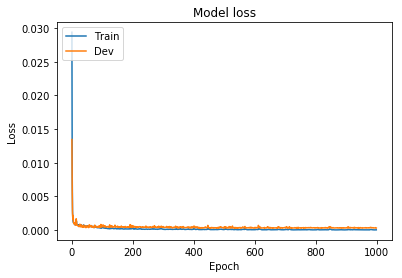

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()